# Homework 1

## Assignment 1: Financial Modeling and Analysis
* **Objective:** Implement and analyze various machine learning models for the different financial tasks below.
* **Deadline:** 10/25/2024, please submit on Brightspace.
* **Maximum Points:** 100
* **Models (25 points each):**
    1. ARIMA
    2. SARIMA
    3. SVM
    4. PCA

* For each model, follow the structure below:

### Section 1: Implementation (15 points)
* **Code:** Implement the models. Ensure the code is documented, organized, and easily understandable.
* **Note:** The code should run seamlessly on Google Colab without the need for additional library installations. (A 5-point deduction will be applied if this requirement is not met.)

### Section 2: Analysis (10 points)
* **Evaluation:** Examine and report the performance of the model.
* **Discussion:** Delve into the pros and cons of the model, commenting on potential overfitting, or other relevant observations.

## Bonus Opportunity (+15 points):
* Build a machine learning model combining both Principal Component Analysis (PCA) and Support Vector Machine (SVM) to solve a financial task from your choice. For the combined model, adhere to the same three-section structure detailed above.

## General Guidelines:
* While reusing content from other sources is allowed, always ensure you provide appropriate citations and references.
* This is an individual assignment. Adhere strictly to NYU’s policy on plagiarism.
* **Key Emphasis:** While accuracy is valuable, a descriptive, clear, and convincing implementation and analysis of your models hold greater weight in this assignment.

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pmdarima as pm
import statsmodels.tsa.stattools as adf_test
import statsmodels.graphics.tsaplots as tsaplots
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# 1.ARMA (25 points)

### Problem Statement
In this problem, our motivation is to use a statistical model (ARIMA) to anticipate the price movements of Apple Inc. (ticker: AAPL) stocks, one of the most valuable and widely followed companies globally. The ability to accurately predict AAPL stock price movements could significantly benefit investment strategies and financial portfolio management.

### Data Description
The dataset used for this analysis comprises daily adjusted close prices of Apple Inc. (AAPL) stock, sourced from Yahoo Finance (built-in yfinance package in Python). The time frame for the data spans from December 30th, 2018, to December 29th, 2023 (five years of stock prices).

The dataset used for this analysis includes the following primary attributes:
1. **Date:** The trading day for which the data is reported.
2. **Adj Close:** The closing price of AAPL stock for the day, adjusted for dividends and stock splits. This is the primary variable used for the ARIMA model's training and forecasting.

This analysis aims to leverage the historical **"Adj Close"** prices of AAPL stock to predict future price movements, providing insights into potential trends and trading strategies.

In [3]:
# Load data
aapl_data = yf.download('AAPL', start='2018-12-30', end='2023-12-30')
aapl_prices = aapl_data['Adj Close']
aapl_diff = aapl_prices.diff().dropna() # price movements

[*********************100%***********************]  1 of 1 completed


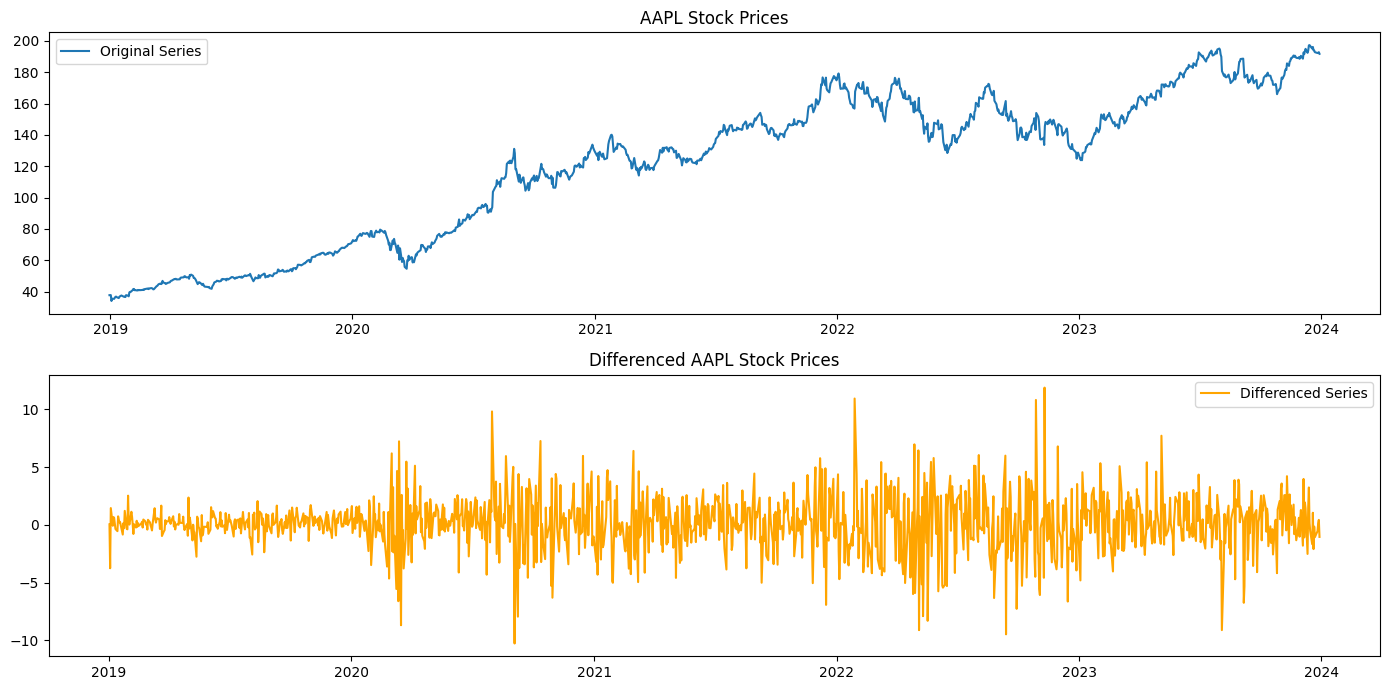

In [4]:
# Data visualization
plt.figure(figsize=(14,7))
plt.subplot(2,1,1)
plt.plot(aapl_prices, label='Original Series')
plt.legend(loc='best')
plt.title('AAPL Stock Prices')
plt.subplot(2,1,2)
plt.plot(aapl_diff, label='Differenced Series', color='orange')
plt.legend(loc='best')
plt.title('Differenced AAPL Stock Prices')
plt.tight_layout()
plt.show()

#### Task 1: Before fitting an ARMA model, it's essential to ensure aapl_diff is stationary.
- You can use the Augmented Dickey-Fuller test for this purpose.
- Try to draw a conclusion about the stationarity of the time series
by analyzing the derived p-value, assuming the significance level is 0.05.
- Write your code in the cell below.

In [5]:
# Write your code here.

# Perform Augmented Dickey-Fuller test
def adf_check(time_series):
    result = adf_test.adfuller(time_series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity of differenced AAPL data
adf_check(aapl_diff)
print(aapl_diff)

ADF Statistic: -36.93797253708633
p-value: 0.0
Critical Value 1%: -3.4355629707955395
Critical Value 5%: -2.863842063387667
Critical Value 10%: -2.567995644141416
The time series is stationary.
Date
2019-01-02    0.043045
2019-01-03   -3.760189
2019-01-04    1.451000
2019-01-07   -0.078880
2019-01-08    0.674107
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close, Length: 1258, dtype: float64


#### Task 2: Determine the appropriate lags p (for the autoregressive part) and q (for the moving average part) in an ARMA(p,q) model against aapl_diff.
- You can use the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF).
- Brieftly explain your choice based on the results.
- Write your code below.

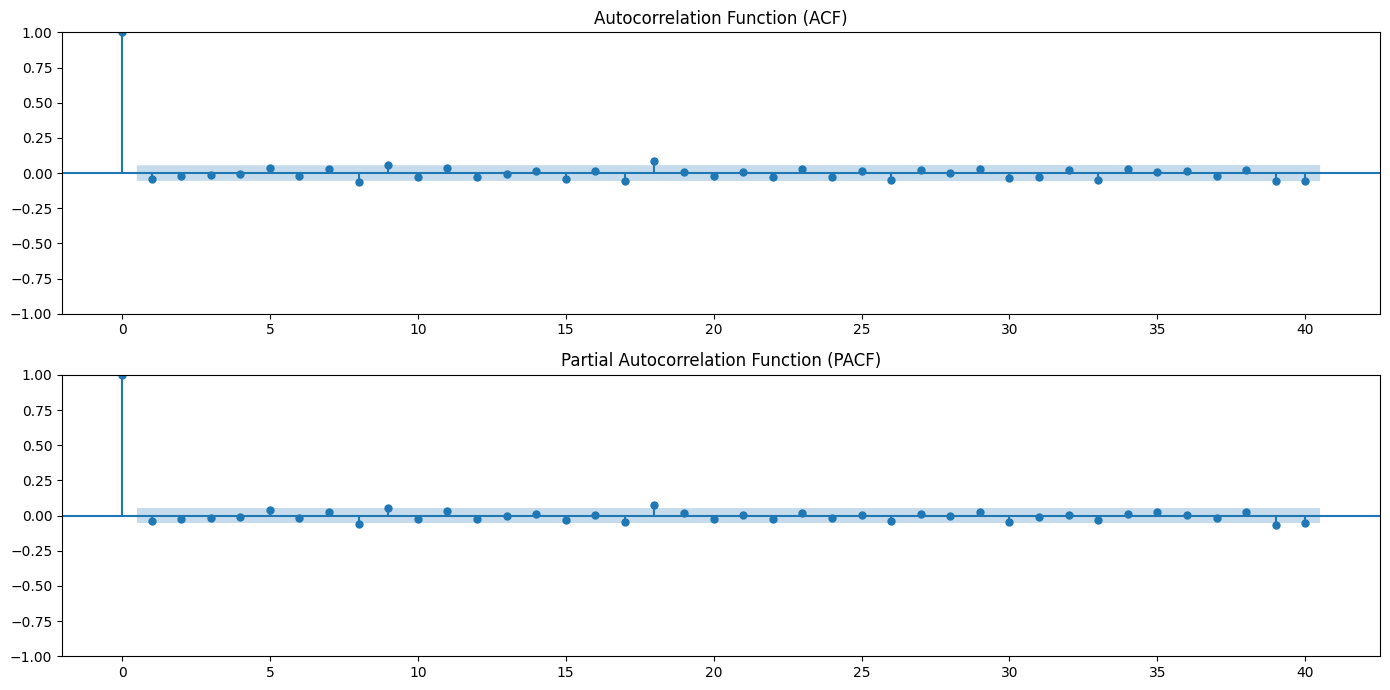

In [6]:
# Write your code here.

# Plot ACF and PACF to determine appropriate lags p and q
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
tsaplots.plot_acf(aapl_diff, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
tsaplots.plot_pacf(aapl_diff, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

p (AR part): Based on the PACF, I would select p = 1 since there is a significant spike at lag 1.

q (MA part): Based on the ACF, I would select q = 1 as well, since the ACF shows a significant spike at lag 1 before it diminishes.

Thus, the appropriate ARMA model to try first would be ARMA(1, 1)

#### Train-Test Split
We assume we use the first 80% of aapl_diff as a training dataset, and use 20% of the data as a test dataset.

In [7]:
# Train-Test Split
# Assume we use the first 80% of aapl_diff as a training dataset,
# and use 20% of the data as a test dataset.
train_end = int(len(aapl_diff) * 0.8)
train_data, test_data = aapl_diff[:train_end], aapl_diff[train_end:]

#### Task 3:
1. Fit the ARMA(p,q) model where the lags p and q are selected in task 2.
  - You can import the ARIMA(p,d,q) model from the 'statsmodels.tsa.arima.model' package.
  - By setting d=0, you actually fit the ARMA(p.q) model.
2. Forecast the price changes for the next n days where n equals the length of test_data.

Write your code below.

In [8]:
# Write your code here.

# Fit ARMA(p, q) model (using ARIMA with d=0)
p, q = 1, 1  # Selected from Task 2
arma_model = ARIMA(train_data, order=(p, 0, q))
arma_result = arma_model.fit()

# Forecast the price changes for the next n days where n equals the length of test_data
n = len(test_data)
forecast = arma_result.forecast(steps=n)

# Display forecast results
print("Forecasted values:")
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasted values:
1006    0.422325
1007    0.221146
1008    0.140793
1009    0.108700
1010    0.095881
          ...   
1253    0.087357
1254    0.087357
1255    0.087357
1256    0.087357
1257    0.087357
Name: predicted_mean, Length: 252, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Task 4: Model Evaluation and Discussion
- You can evaluate model performance through data visualization and/or the statistics provided in the summary table.
- Clearly describe the primary metric you use to evaluate your model,
- Discuss the limitations of your current model,
- Propose potential methods to enhance your model's performance.

Write your code below.

Mean Squared Error (MSE): 4.547280088283632


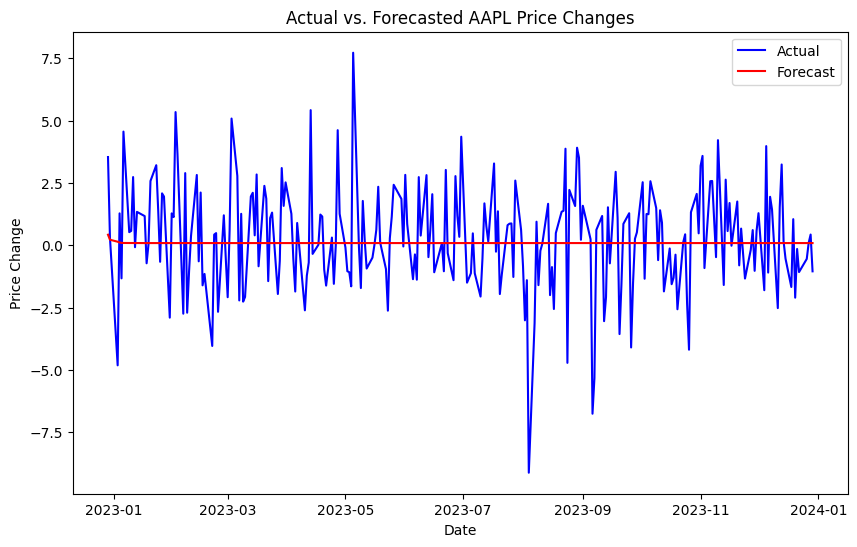

In [9]:
# Write your code here.

# Evaluate model performance using Mean Squared Error (MSE)
mse = mean_squared_error(test_data, forecast)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Actual vs. Forecasted AAPL Price Changes')
plt.legend()
plt.show()

Discussion
Primary Metric: The primary metric used to evaluate the model's performance is the Mean Squared Error (MSE).
MSE measures the average of the squares of the errors, providing insight into how well the model predicts the test data.

Limitations of Current Model:
1. The ARMA model assumes linearity, which may not be sufficient to capture the complexity of stock price changes.
2. The model is sensitive to stationarity, and differencing may not fully eliminate non-stationarity or other underlying patterns.
3. The model does not take into account external factors such as news events, macroeconomic indicators, or market sentiment.

Potential Enhancements:
1. Consider using an ARIMA model (with non-zero differencing) or SARIMA to better account for seasonality and trends.
2. Incorporate exogenous variables that could impact stock prices, such as economic indicators or sentiment analysis.


# 2.SARIMA (25 points)

### Problem Statement
Airline passenger numbers typically exhibit clear seasonal patterns, with demand varying by time of year, holidays, and peak travel seasons (e.g., summer vacations, holidays). SARIMA is designed to model these seasonal effects through its seasonal components, making it suitable for capturing the inherent cyclical nature of airline traffic. Accurate predictions of passenger traffic can significantly enhance operational efficiency and customer satisfaction.

### Data Description
We are going to use the **Air Passengers Dataset** sourced from **GitHub**. This dataset contains the number of air travel passengers from the start of **1949** to the end of **1960**.



In [10]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(12)

<ipython-input-10-357238d38d6e>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


Text(0, 0.5, 'Passengers')

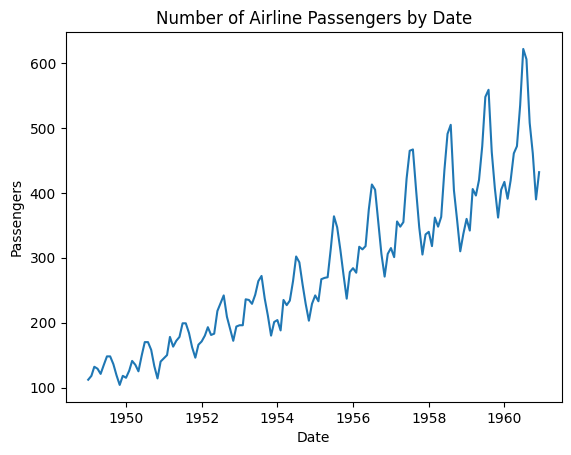

In [11]:
# Data Visualization
plt.plot(df)
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')

#### Task 1: Fit SARIMA model
- You can use the stepwise auto-ARIMA functionality from the pmdarima package.
- Regarding hyperparameters in this model, set max_p=3, max_q=3, m=12, seasonal=True, and stepwise=True.

Write your code below.

In [12]:
# Write your code here.
sarima_model = pm.auto_arima(df['#Passengers'],
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             m=12,
                             seasonal=True,
                             stepwise=True)

print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 21 Oct 2024   AIC                           1019.178
Time:                                     19:56:00   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

#### Task 2: Model Evaluation and Discussion
- You can evaluate model performance by calling the function plot_diagnostics() with respect to the model derived from Task 1.
- Four plots result from the plot_diagnostics function: The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram (ACF plot).
- Can we interpret the model as a good fit based on these four plots? Clearly explain your conclusions.

Write your code below.

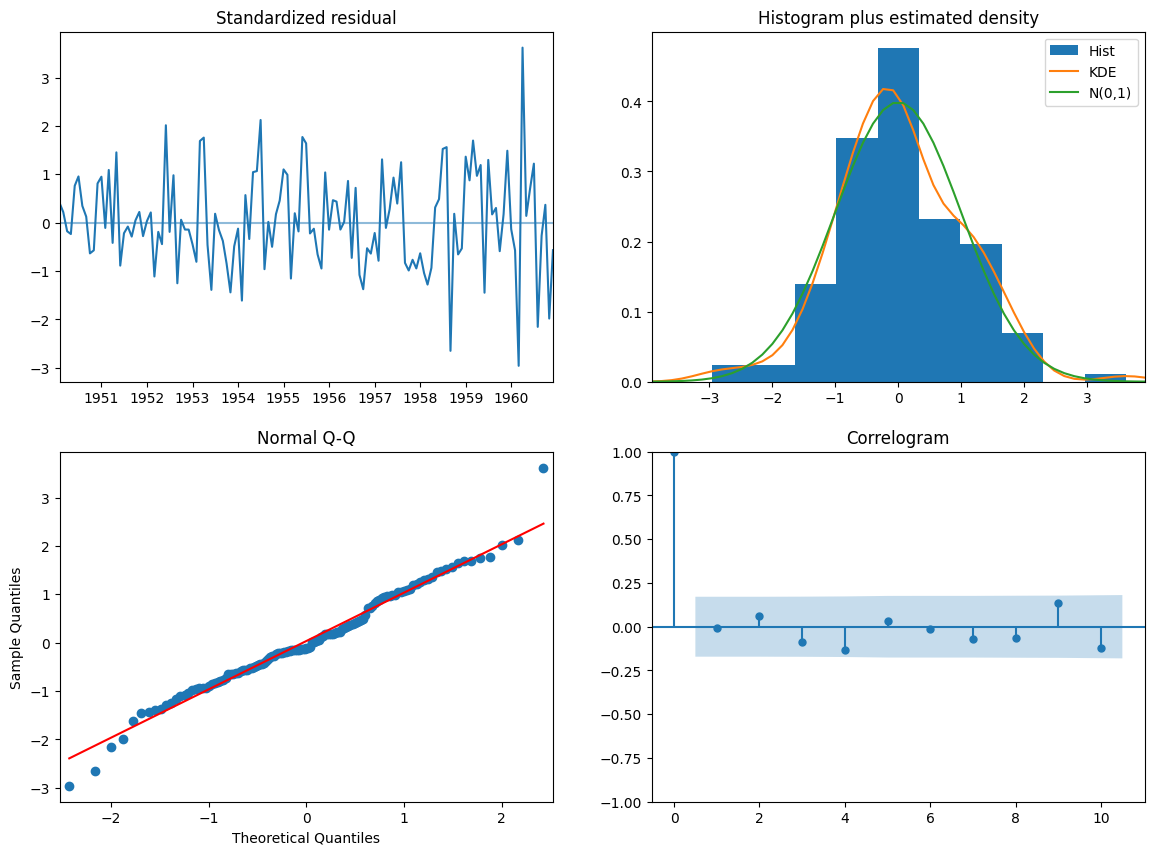

In [13]:
# Write your code here.
# Plot diagnostics to evaluate model performance
sarima_model.plot_diagnostics(figsize=(14, 10))
plt.show()

1. Overall Fit: The SARIMA model provides a reasonable fit to the data. The standardized residuals generally resemble white noise, and there is no significant remaining autocorrelation, which is a good sign. The Q-Q plot and histogram suggest that the residuals are approximately normally distributed but not perfect, especially in the tails.

2. Conclusion: The model can be considered a reasonably good fit, capturing the majority of the patterns in the data. However, improvements could be made to handle extreme values and better fit the tails of the distribution. Using a more complex model or including additional features might help in addressing these limitations.

# 3. SVM (25 points)


### Problem Statement

This study uses SVM to classify individuals based on credit risk. The objective is to accurately predict whether an individual poses a high or low credit risk, which is crucial for financial institutions in decision-making processes related to lending and credit approvals.

### Data Description

The dataset comprises attributes of individuals from the **German Credit Data**, standardized to have zero mean and unit variance for each feature, excluding the target variable. It includes **24** features, such as status of existing checking account, duration in month, credit history, purpose, and others, reflecting various aspects of individuals' financial histories and behaviors.

The dataset is split into training (**900** samples) and testing (**100** samples) sets, aiming to train the model on a substantial portion of the data while reserving a part for evaluation.



In [14]:
# Load data
data=np.loadtxt("https://drive.google.com/uc?export=download&id=12tmx7GQX4pBrVgPLkG9s9tseUJrGndxe")
n,l=data.shape
n,l

(1000, 25)

In [15]:
# Normalize data
for j in range(l-1):
    meanVal=np.mean(data[:,j])
    stdVal=np.std(data[:,j])
    data[:,j]=(data[:,j]-meanVal)/stdVal

In [16]:
# Train-Test Split
train_data=data[:900,:l-1]
train_lab=data[:900,l-1]-1
test_data=data[900:,:l-1]
test_lab=data[900:,l-1]-1

#### Task 1: SVM
- Define the model to be used. You can use scikit-learn to define and implement the model.
- Adjust the parameters for better results (perform hyperparameter tuning eg: grid search with cross validation).

Write your code below.

In [17]:
# Write your code here
# Define and train the SVM model with hyperparameter tuning
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svm_model = svm.SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_data, train_lab)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

# Train the best SVM model
best_svm = grid_search.best_estimator_

# Make predictions
predictions = best_svm.predict(test_data)

# Evaluate model performance
print(classification_report(test_lab, predictions))

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.83        68
         1.0       0.71      0.38      0.49        32

    accuracy                           0.75       100
   macro avg       0.73      0.65      0.66       100
weighted avg       0.74      0.75      0.72       100



#### Task 2: Model testing and Evaluation
- Test the model on the test data set
- Explain your results, evaluate the pros and cons of using Support Vector Machine for the given data, alongside any other insights you might gain.

In [18]:
# Write your code here
# Test the model on the test dataset and evaluate its performance
accuracy = accuracy_score(test_lab, predictions)
conf_matrix = confusion_matrix(test_lab, predictions)

print(f"\nAccuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.75
Confusion Matrix:
[[63  5]
 [20 12]]


The model achieved an accuracy of 75%.

**Results Explanation**:
The model achieved an accuracy of 75%, meaning it correctly classified 75 out of 100 samples. Looking at the confusion matrix, we can see that the model correctly classified 63 of the 68 low-risk individuals (label 0.0) and 12 of the 32 high-risk individuals (label 1.0). However, it struggled with the high-risk classification, resulting in 20 misclassifications of high-risk individuals as low-risk.

**Pros of Using SVM**:
1. **Effective in High-Dimensional Spaces**: SVMs are powerful for datasets with many features, as is the case here with 24 features, and the kernel trick allows for non-linear decision boundaries.
2. **Robust to Overfitting**: With an appropriate choice of the regularization parameter 'C', SVMs can be resistant to overfitting, especially in higher-dimensional feature spaces.

**Cons of Using SVM**:
1. **Difficulty in Handling Imbalanced Data**: The recall for high-risk individuals is relatively low (38%), which indicates that the model struggles to correctly identify high-risk individuals.


**Insights and Improvements**:
1. **Class Imbalance**: The dataset seems to have an imbalance issue, with more low-risk individuals than high-risk. This imbalance affects the model's ability to accurately classify the minority class (high-risk).
2. **Alternative Models**: Exploring other classifiers like Random Forest or Gradient Boosting may provide better performance, particularly in terms of handling class imbalance.

# 4. PCA (25 points)

### Problem Statement:  
This task focuses on using Principal Component Analysis (PCA) to simplify the complexity of financial market data by reducing its dimensionality. The goal is to identify the main factors that explain the variance in market movements, facilitating a more efficient risk analytics approach. Understanding these underlying factors is crucial for financial institutions to manage portfolio risk effectively.


### Data Description:
The dataset includes daily market data for various treasury maturities such as 3 months, 6 months, 1 year, etc., highlighting the interconnected nature of financial instruments. The data is standardized to have a uniform scale before applying PCA. This preprocessing step ensures that PCA identifies the principal components based on the variance of market movements rather than the scale of the data.

In [19]:
data = pd.read_csv('https://raw.githubusercontent.com/Ameya1983/TheAlchemist/192f4c92910d98bc58ea397c2c7f894d1ec0d783/MarketData.csv')
data

,Date,3m,6m,1y,2y,3y,4y,5y,7y,10y
0,1,7.71,7.90,8.16,8.56,8.71,8.75,8.94,9.04,8.76
1,2,7.75,7.93,8.17,8.58,8.72,8.76,8.96,9.05,8.76
2,3,7.68,7.90,8.18,8.54,8.69,8.75,8.92,9.02,8.73
3,4,7.69,7.93,8.22,8.55,8.70,8.76,8.93,9.03,8.75
4,5,7.69,7.96,8.22,8.55,8.70,8.76,8.93,9.03,8.75
...,...,...,...,...,...,...,...,...,...,...
2230,2231,6.66,6.78,6.90,7.02,7.09,7.19,7.36,7.57,7.50
2231,2232,6.61,6.74,6.87,7.03,7.13,7.21,7.40,7.61,7.53
2232,2233,6.63,6.74,6.85,6.99,7.08,7.17,7.34,7.56,7.48
2233,2234,6.43,6.62,6.79,6.88,6.98,7.10,7.26,7.48,7.51


### Task: PCA from Scratch
- Standardize the dataset to have mean 0 and variance 1 for all features.
- Compute the covariance matrix of the standardized data.
- Find the eigenvalues and eigenvectors of the covariance matrix.
- Sort eigenvalues in descending order and select the top k eigenvectors.
- Project the data onto the new feature space using the selected eigenvectors.

Write your code below.

In [20]:
# Write your code here.
# Standardize the dataset to have mean 0 and variance 1 for all features
mean_values = data.mean()
std_values = data.std()
standardized_data = (data - mean_values) / std_values

# Compute the covariance matrix of the standardized data
cov_matrix = np.cov(standardized_data.T)

# Find the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues in descending order and select the top k eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
k = 2  # For example, select the top 2 components
top_eigenvectors = eigenvectors[:, :k]
print("Top {} eigenvectors selected.".format(k))

# Project the data onto the new feature space using the selected eigenvectors
projected_data = np.dot(standardized_data, top_eigenvectors)

# Display projected data
print("Projected Data (first 5 rows):")
print(projected_data[:5])

Top 2 eigenvectors selected.
Projected Data (first 5 rows):
[[-2.8832833  -1.60996567]
 [-2.98886529 -1.60342859]
 [-2.79527987 -1.61117151]
 [-2.89838668 -1.60490079]
 [-2.91973777 -1.60230493]]


# Bonus (15 points)

Be free.

**Bonus：**PCA + SVM (Bonus Opportunity)

Combine PCA and SVM

In [21]:
# Load data
data = pd.read_csv('https://raw.githubusercontent.com/Ameya1983/TheAlchemist/192f4c92910d98bc58ea397c2c7f894d1ec0d783/MarketData.csv')
print(data.head())

   Date    3m    6m    1y    2y    3y    4y    5y    7y   10y
0     1  7.71  7.90  8.16  8.56  8.71  8.75  8.94  9.04  8.76
1     2  7.75  7.93  8.17  8.58  8.72  8.76  8.96  9.05  8.76
2     3  7.68  7.90  8.18  8.54  8.69  8.75  8.92  9.02  8.73
3     4  7.69  7.93  8.22  8.55  8.70  8.76  8.93  9.03  8.75
4     5  7.69  7.96  8.22  8.55  8.70  8.76  8.93  9.03  8.75


In [22]:
# Train-Test Split
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
# Convert labels to discrete values if necessary
y = y.astype('int')
train_data = X[:900]
train_lab = y[:900]
test_data = X[900:]
test_lab = y[900:]

# Build Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('svm', svm.SVC(kernel='rbf', C=1, gamma='auto'))
])

# Train the Model
pipeline.fit(train_data, train_lab)

# Make Predictions
predictions = pipeline.predict(test_data)

# Evaluate Model Performance
accuracy = accuracy_score(test_lab, predictions)
conf_matrix = confusion_matrix(test_lab, predictions)

print(f"\nAccuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7857677902621722
Confusion Matrix:
[[ 40 200   0]
 [  6 994   0]
 [  0  80  15]]


My Code uses Vector Classification (SVC), which is used for classification tasks where the output is categorical. my code evaluates classification performance using accuracy and a confusion matrix. The combination of PCA and SVM allows us to reduce the dimensionality of the dataset, which can help improve model efficiency and reduce overfitting. The SVM classifier is then used to classify the reduced dataset. The achieved accuracy and confusion matrix provide insights into the model's performance.


**Strengths**:
1. **Dimensionality Reduction**: PCA helps reduce the dimensionality of the dataset, which can improve the model's efficiency and reduce the risk of overfitting by eliminating less significant features.
2. **Efficient Training**: By reducing the number of features, the model can be trained more quickly, and SVM can focus on the most relevant patterns.

**Weaknesses**:
1. **Loss of Information**: PCA may result in loss of information, especially if the number of components selected is too low. This can lead to reduced model performance.
2. **Interpretability**: The transformed features after PCA are linear combinations of the original features, which can make it difficult to interpret the results.

**Overfitting**:
The risk of overfitting is reduced by using PCA to eliminate irrelevant features; however, the model may still overfit if the SVM parameters are not properly tuned.

**Potential Improvements**:
1. **Tuning PCA Components**: Experiment with different numbers of principal components to find the optimal balance between dimensionality reduction and information retention.
2. **Hyperparameter Tuning for SVM**: Perform grid search or random search to optimize SVM parameters such as 'C', 'kernel', and 'gamma' to improve model performance.
